In [2]:
from helpers import helper_functions
import time
import os

import tensorflow as tf
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import yaml

Using TensorFlow backend.


In [3]:
#root_dir='/global/cscratch1/sd/abbatej/autoruns/no_smoothing/numlayers_0_densact_linear_denssize_20'
#root_dir='/global/homes/a/abbatej/plasma_profiles_predictor/test_models'
#root_dir='/global/homes/a/abbatej/plasma_profiles_predictor'
root_dir='/global/cscratch1/sd/abbatej/autoruns/pca_tests/n_components_8/'
input_dir='/global/homes/a/abbatej/'
model_filename='model.h5'
#model_filename='gru_cnn_renormed_40.h5'

def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config
config=load_config(root_dir+'conf.yaml')['data']

In [4]:
helper_functions.preprocess_data(dirname=config['input_dir_name'], 
                sigs_0d=config['sigs_0d'],
                sigs_1d=config['sigs_1d'],
                n_components=config['n_components'],
                avg_window=config['avg_window'],
                lookback=config['lookback'],
                delay=config['delay'],
                train_frac=config['train_frac'],
                val_frac=config['val_frac'],
                save_data=True)

Removed 15 shots with empty arrays


In [5]:
rho_points = helper_functions.load_obj(input_dir+'rho_standard')

In [41]:
sig_names = ['Target current (A)', 'Injected power (kW)', 'Injected torque (Nm)']#, 'Gas A']
sig_keys = ['curr_target', 'pinj', 'tinj'] #['curr_target', 'pinj', 'tinj']
num_sigs=len(sig_names)

In [6]:
# matplotlib setup
%matplotlib inline

In [7]:
train_data = np.array(helper_functions.load_obj(input_dir+'train_data'))
train_target = np.array(helper_functions.load_obj(input_dir+'train_target'))
val_data = np.array(helper_functions.load_obj(input_dir+'val_data'))
val_target = np.array(helper_functions.load_obj(input_dir+'val_target'))

In [8]:
shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
train_shots = shot_indices_dictionary['train_shot_names']
val_shots = shot_indices_dictionary['val_shot_names']
train_shot_inds = shot_indices_dictionary['train_shot_indices']
val_shot_inds = shot_indices_dictionary['val_shot_indices']

In [9]:
train_time = np.array(helper_functions.load_obj(input_dir+'train_time'))
val_time = np.array(helper_functions.load_obj(input_dir+'val_time'))

In [10]:
means = helper_functions.load_obj(input_dir+'means')
stds = helper_functions.load_obj(input_dir+'stds')

In [11]:
loaded_model=models.load_model(os.path.join(root_dir,model_filename))

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')

In [12]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 11)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 40)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
Total params: 7,470
Trainable params: 7,470
Non-trainable params: 0
_________________________________________________________________


In [13]:
input_data=val_data
output_data=val_target

#################################################
#################################################
#################################################

BEGIN taking code for mean value of electron temp

#################################################
#################################################
#################################################

In [90]:
train_data[:,:,:3]=0#np.random.normal(size=val_data[:,:,:3].shape)

In [81]:
avg_val_mae_new = loaded_model.evaluate(val_data,val_target)[1] #mae is the second entry
#avg_baseline_mae_new =np.mean(abs(np.diff(np.ndarray.flatten(val_target))))


41829/41829 [==============================] - 2s 51us/step


In [91]:
train_mae_new = loaded_model.evaluate(train_data,train_target)[1] #mae is the second entry

132191/132191 [==============================] - 7s 52us/step


In [92]:
print(train_mae_new)

0.03814040272516586


In [83]:
print(avg_val_mae)
print(avg_baseline_mae)

0.03195699544537062
0.027433548422148565


ValueError: x and y must have same first dimension, but have shapes (191,) and (5730,)

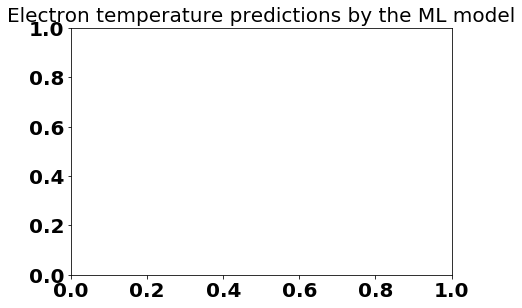

In [283]:
titlesize=20
othersize=20
legendsize=15
linewidth=7
smalllinewidth=3
num_sigs=3

train=False
timestep=0
if(train):
    data=train_data
    target=train_target
    shot_nums=train_shots
    shot_inds=train_shot_inds
else:
    data=val_data
    target=val_target
    shot_nums=val_shots
    shot_inds=val_shot_inds

index = np.searchsorted(shot_inds, timestep, side='right')-1
times=list(range(shot_inds[index],shot_inds[index+1]))

true_times = train_time if train else val_time

shot_num=shot_nums[index]

input_data=data[times]
#input_data[:,:,:3]=0

pred=loaded_model.predict(input_data)
true=target[times]
prev=input_data[times,-1,num_sigs:] #needed to make this commas; before it was [][][]

sigs_all_times=np.array(data)[times,-1,:].T

fig = plt.figure()

baseline_error = abs(true-prev)
pred_error = abs(true-pred)

ax = fig.add_subplot('222')
ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
ax.plot(true_times[times],np.ndarray.flatten(pred),label='Predicted', linewidth=smalllinewidth)

ax.plot(true_times[times],np.ndarray.flatten(true),label='True', linewidth=smalllinewidth)
ax.plot(true_times[times],np.ndarray.flatten(prev),label='Previous', linewidth=smalllinewidth)
ax.set_ylabel('Normalized e_temp', fontsize=othersize)
#ax.set_xlim(0,1)
#ax.set_xlabel('Normalized rho', fontsize=othersize)
ax.legend(loc='best', fontsize=legendsize)

ax = fig.add_subplot('224')
ax.set_title('Error in e_temp predictions', fontsize=titlesize)
ax.plot(true_times[times], np.ndarray.flatten(pred_error), color='red', label='Model error for one example', linewidth=linewidth)
ax.axhline(avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
ax.plot(true_times[times], baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
ax.axhline(avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
#ax.set_ylim(0,.4)
#ax.set_xlim(0,1)
ax.legend(loc='upper left', fontsize=legendsize)
ax.set_ylabel('Error (abs val)', fontsize=othersize)
ax.set_xlabel('Time', fontsize=othersize)

    #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
    #ax.text(0.05,0.1,textstr, transform=ax.transAxes)

#plt.subplots_adjust(hspace=.5)

for i in range(num_sigs):
    which_plot='{}2{}'.format(num_sigs,2*i+1)
    ax=fig.add_subplot(which_plot) #axes[i+1]
    #ax.plot(times,sigs_all_times[i])
    ax.plot(true_times[times],(sigs_all_times[i]*stds[sig_keys[i]])+means[sig_keys[i]])
    ax.set_ylabel(sig_names[i], fontsize=titlesize)
    ax.axvline(true_times[timestep],color='r')
    if i==num_sigs-1:
        ax.set_xlabel('Time (ms)', fontsize=othersize)

fig.suptitle('Shot {}'.format(shot_num))
plt.show()

#################################################
#################################################
#################################################

END taking code for mean value of electron temp

#################################################
#################################################
#################################################

#####################################################
#####################################################
#####################################################

BEGIN TAKING RAMPUP ONLY

#####################################################
#####################################################
#####################################################

In [110]:
timesteps_in_rampup=10

input_data=[]
output_data=[]
for shot_ind in val_shot_inds:
    input_data.extend(val_data[shot_ind:shot_ind+timesteps_in_rampup])
    output_data.extend(val_target[shot_ind:shot_ind+timesteps_in_rampup])
#zerod_input_data has every 10th entry set to 0
zerod_input_data=input_data.copy()

input_data=np.array(input_data)
output_data=np.array(output_data)

zeroes = np.zeros((input_data.shape[1],input_data.shape[2]))
zerod_input_data[::timesteps_in_rampup]=[zeroes]*len(zerod_input_data[::timesteps_in_rampup])

In [111]:
new_input=input_data.copy()
new_input[:,:,0]+=new_input[:,:,0]*1.2

In [112]:
print(15%10)

5


1942
Shot 164349, 
2 timesteps in


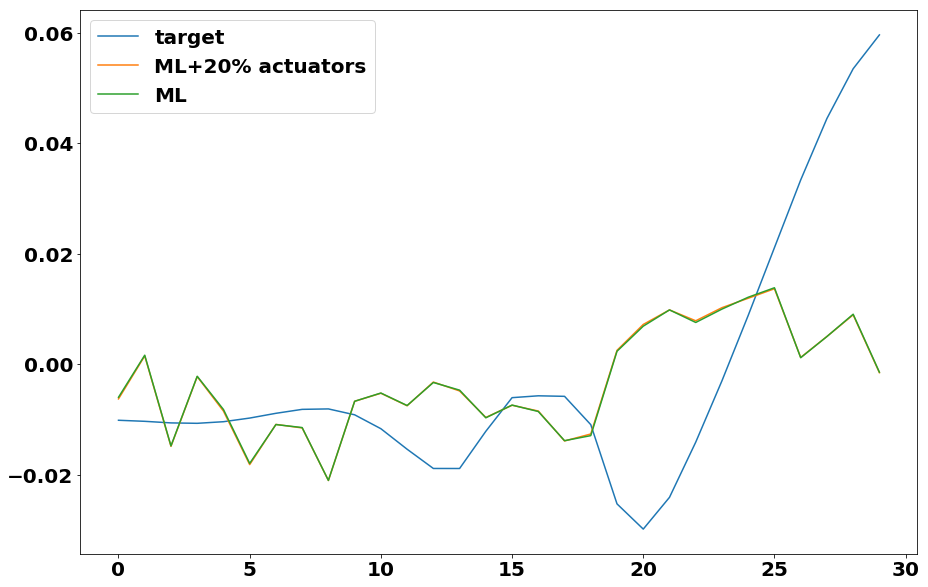

In [167]:
i=np.random.randint(len(output_data))
print(i)
print('Shot {}, \n{} timesteps in'.format(val_shots[int(i/10)],i%10))
#plt.plot(input_data[:,-1,num_sigs:][i]+np.diff(input_data[:,-1,num_sigs:],axis=0)[i-1],label='linear prop')
#plt.plot(input_data[:,-1,num_sigs:][i],label='prev profile')
plt.plot(output_data[i],label='target')

plt.plot(loaded_model.predict(new_input[i:i+1])[0],label='ML+20% actuators')
plt.plot(loaded_model.predict(input_data[i:i+1])[0],label='ML')
plt.plot()
plt.legend()
plt.show()

#####################################################
#####################################################
#####################################################

END TAKING RAMPUP ONLY

#####################################################
#####################################################
#####################################################

In [27]:
# Get ML model performance
val_mae = abs(loaded_model.predict(input_data)-output_data)

# Compared to having signals zeroed out
input_data_zeroed=np.copy(input_data)
input_data_zeroed[:,:,:3]=0
val_mae_holdout = abs(loaded_model.predict(input_data_zeroed)-output_data)

In [28]:
avg_val_mae=np.mean(val_mae, axis=0)
std_val_mae=np.std(val_mae, axis=0)

In [30]:
avg_val_mae_holdout=np.mean(val_mae_holdout, axis=0)[0]
std_val_mae_holdout=np.std(val_mae_holdout, axis=0)[0]

In [31]:
# Get performance based on simply guessing the previous timestep
#np.diff(input_data[:,-1,num_sigs:],axis=0)
#baseline_mae=abs(np.diff(input_data[:,-1,num_sigs:],axis=0))
baseline_mae=abs(output_data)

In [33]:
avg_baseline_mae=np.mean(baseline_mae, axis=0)
std_baseline_mae=np.std(baseline_mae, axis=0)

In [34]:
plt.rcParams['figure.figsize'] = [15, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

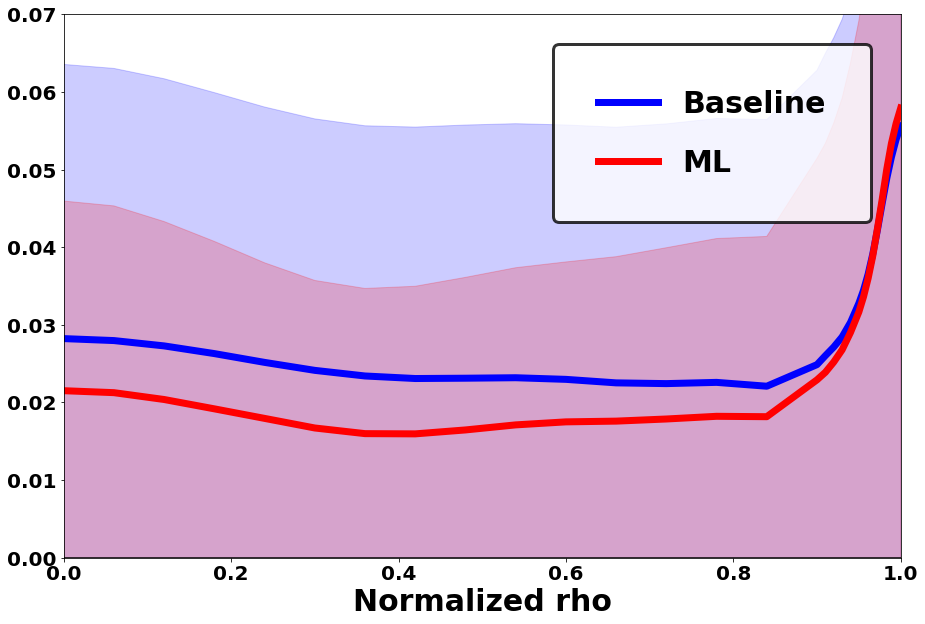

In [35]:
# plt.plot(rho_points,avg_val_mae, c='r', alpha=.5)
# plt.plot(rho_points, avg_baseline_mae, c='b', alpha=.5)
plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

plt.plot(rho_points, avg_baseline_mae, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,avg_val_mae, c='r', label='ML', linewidth=7.0)
# plt.plot(rho_points,avg_val_mae_holdout, c='b', label='ML no actuators', linewidth=7.0)
# plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
# plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
#plt.title('Comparing prediction error with and without rho=30', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
#plt.ylabel('(Model with rho=30) - (Model without rho=30)', fontweight='heavy', fontsize=30)
plt.axhline(0,c='k')
plt.ylim(0,.07)
plt.xlim(0,1.0)
plt.show()

################
################

FOR PREDICTING ACTUAL VALUE RATHER THAN DIFFERENCES

################
################

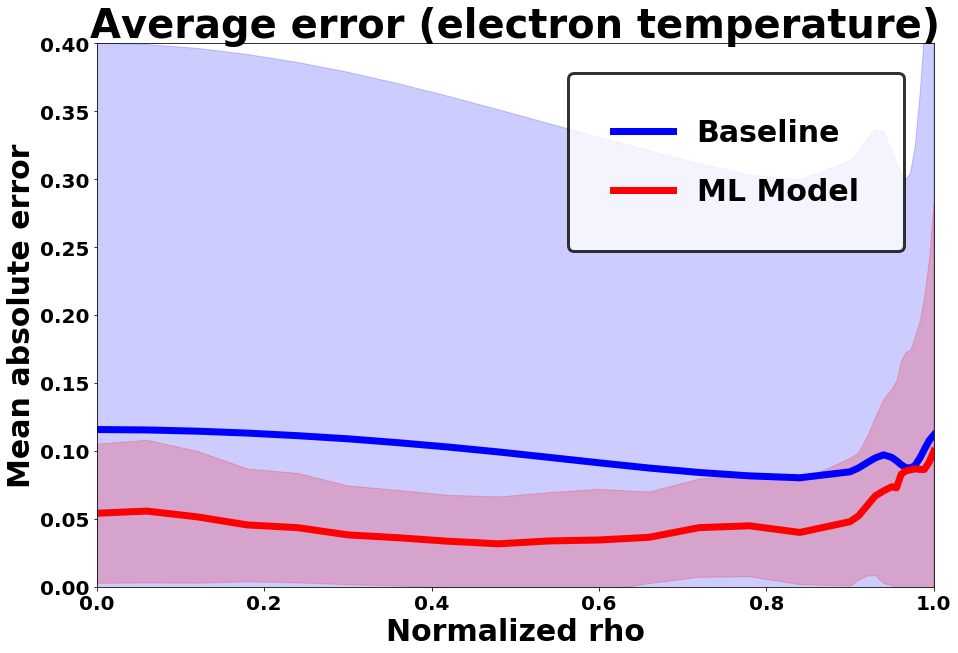

In [121]:
#plt.errorbar(list(range(22)),avg_val_mae, yerr=std_val_mae,c='orange', alpha=.5)
#plt.errorbar(list(range(22)), avg_baseline_mae, yerr=std_baseline_mae, c='b', alpha=.5)

plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

plt.plot(rho_points, avg_baseline_mae, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,avg_val_mae, c='r', label='ML Model', linewidth=7.0)

leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
plt.title('Average error (electron temperature)', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
plt.ylabel('Mean absolute error', fontweight='heavy', fontsize=30)
plt.ylim(0,.4)
plt.xlim(0,1.0)
plt.show()

################
################

END FOR PREDICTING ACTUAL VALUE RATHER THAN DIFFERENCES

################
################

In [61]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_timestep(timestep, train=False, normalized=True, perturbations=[.1,.5,1]):
    
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))
    
    true_times = train_time if train else val_time

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:num_sigs] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    for perturbation in perturbations:
        input_data_no_actuators=input_data.copy()
        input_data_no_actuators[:,:,:num_sigs]*=(1+perturbation)
        pred_no_actuators=np.ndarray.flatten(loaded_model.predict(input_data_no_actuators))
        
        if normalized:
            pred_no_actuators_real=pred_no_actuators
        else: 
            pred_no_actuators_real = np.multiply(pred_no_actuators,stds['e_temp'])+means['e_temp']
            
        ax.plot(rho_points,pred_no_actuators_real,
                label='Predicted with {0:.0f}% addition to actuators'.format(perturbation*100), 
                linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    ### For regular:
    #ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)
    
    for i in range(num_sigs):
        which_plot='{}2{}'.format(len(sigs),2*i+1)
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[times],sigs_all_times[i])
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys[i]])+means[sig_keys[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_names[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        if i==num_sigs-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {}'.format(shot_num))
    plt.show()

In [37]:
plt.rcParams['figure.figsize'] = [20, 14]
font={'size': 20, 'weight': 'heavy'}
plt.rc('font', **font)

22638


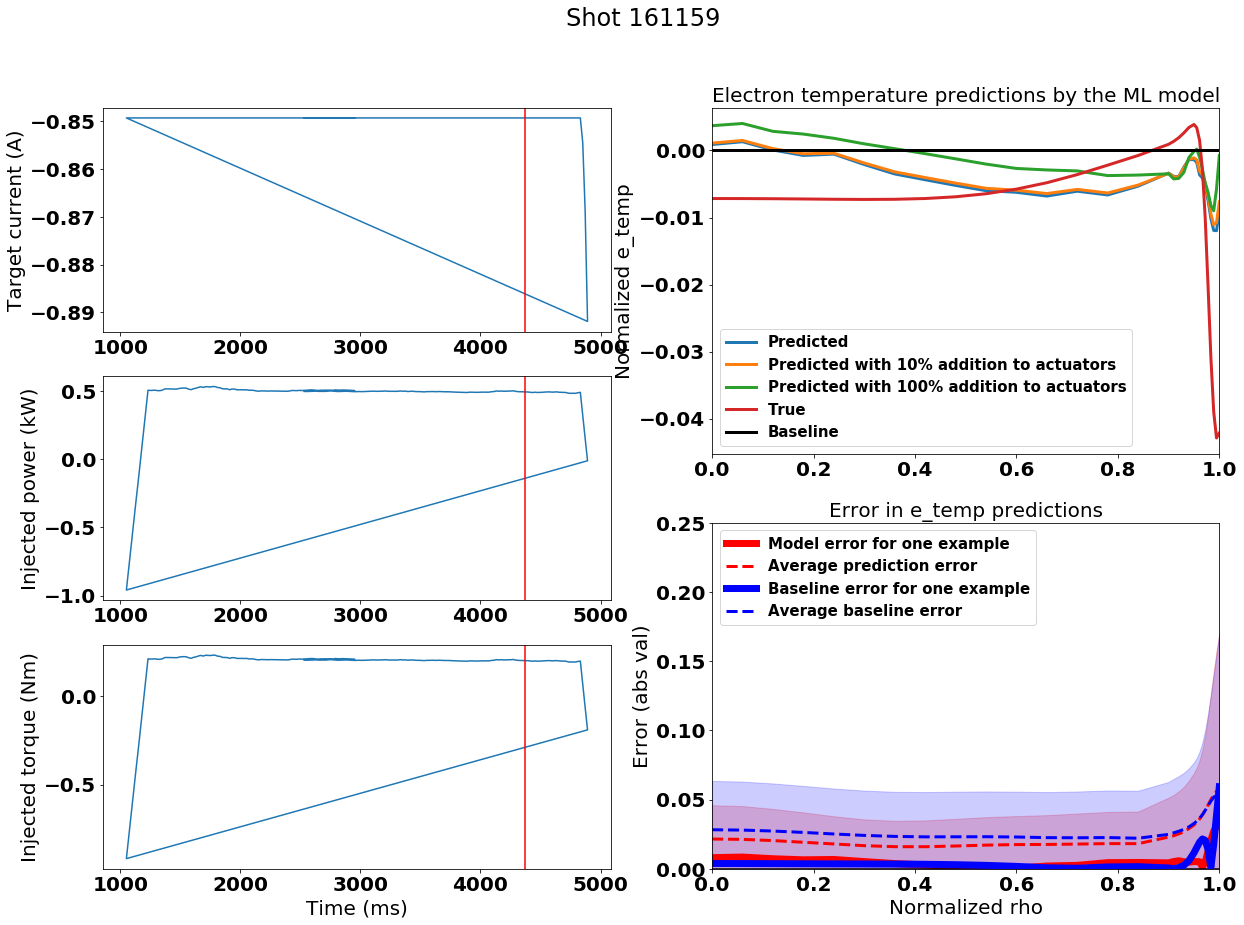

In [83]:
import random
#random.randint(0,len(val_data))
timestep=np.random.choice(val_shot_inds)+np.random.randint(10)
#timestep=6855
print(timestep)
plot_timestep(timestep, train=True, normalized=True, perturbations=[.1,1])

In [80]:
timestep=170
plot_timestep(timestep, errors=False, train=False)

TypeError: plot_timestep() got an unexpected keyword argument 'errors'

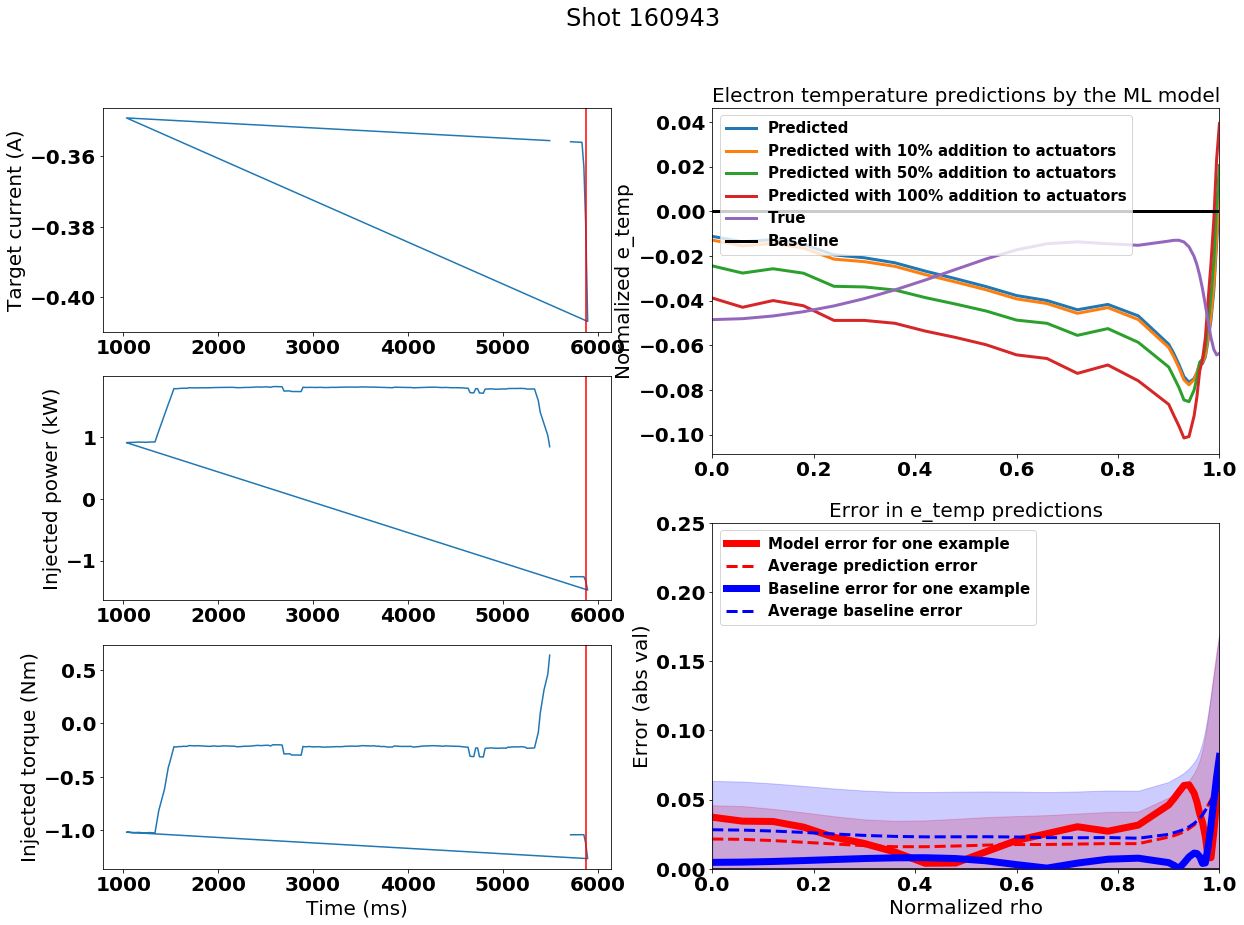

KeyboardInterrupt: 

In [81]:
from IPython.display import clear_output

all_times=list(range(240,250))
k=1
for i in range(int(len(all_times)/k)):
    timestep=all_times[i*k]
    plot_timestep(timestep, train=True)
    time.sleep(3)
    clear_output()

In [ ]:
from IPython.display import clear_output

all_times=list(range(240,250))
k=1
for i in range(int(len(all_times)/k)):
    timestep=all_times[i*k]
    plot_errors(all_times, timestep, train=True)
    time.sleep(3)
    clear_output()